Hello world

In [15]:
from selection_pixels_dtw import *
from sklearn.decomposition import PCA
import os
import cv2
from PIL import Image
import rasterio as rio
import re
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# List of target pixels
pixels_de_interet = pix_danone + pix_agri + pix_ensta + pix_apt + pix_lac + pix_foret
len(pixels_de_interet)

54

In [17]:
dir = "../../ressources/images"
images_list_original = os.listdir(dir)


In [78]:
image = images_list_original[0]
original_shape = rio.open(dir+'/'+image, 'r').read(1).shape
print(original_shape[0], original_shape[1], original_shape[0]*original_shape[1]*140)

973 2182 297232040


In [68]:
nband = 4
images_list_beforePCA = []
images_list_afterPCA = []
for image in images_list_original:
    matrice = np.zeros((len(pixels_de_interet),nband))
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)            
        band3 = ds.read(3)
        band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,0] = band1[pixel[0], pixel[1]]
        matrice[j,1] = band2[pixel[0], pixel[1]]
        matrice[j,2] = band3[pixel[0], pixel[1]]
        matrice[j,3] = band4[pixel[0], pixel[1]]
    pca = PCA(n_components=1)
    matrice_reduced = pca.fit_transform(matrice)
    images_list_beforePCA.append(matrice)
    images_list_afterPCA.append(matrice_reduced)

In [74]:
np.array(images_list_beforePCA)
np.array(images_list_afterPCA).shape

(1, 54, 1)

In [ ]:

images_2A = list()
images_2B = list()
prog = re.compile(r'\w+2A')
for image in images_list:
    if prog.match(image):
        images_2A.append(image)
    else:
        images_2B.append(image)
        
images_2A.sort()
images_2B.sort()
all_images = images_2A + images_2B
all_images = sorted(all_images, key=lambda date: date[16:24])      

In [13]:
list_to_use = all_images
line = 0
matrice = np.zeros((len(pixels_de_interet), len(list_to_use)))
for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        # band1 = raster.read(1)
        # band2 = raster.read(2)
        band3 = ds.read(3)
        # band4 = raster.read(4)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet)-1)):
        matrice[j,line] = band3[pixel[0], pixel[1]]
    line +=1
        

(54, 1)


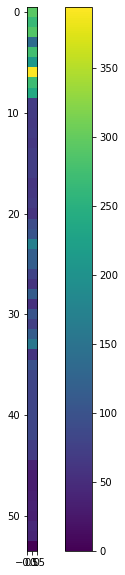

In [16]:
print(matrice.shape)
#Looking for a pixels
img = (matrice/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()